In [1]:
import sys, glob

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gs
from itertools import permutations, combinations
import scipy
donors = [f'TBd{k}' for k in range(1,7)]
TARGET_LOCUS='IGH'

######################## PATH CONFIG ################################

full_df_loc = '../../data/vdj/integrated_cell_calls_ambient_annotated.tsv.gz'
ASC_subtype_df_loc = '../../data/vdj/ASC_subtypes.tab'
sample_relationships_df_loc = '../../snakemake_workflow/samplesheets/sample_relationships.tsv'
FIGURE_OUTDIR = '../figures/paper figures'
######################## ############ ################################
from tb_colormaps import *
plt.style.use('./bursa.mplstyle')


# Read and prepare data for analysis

In [2]:
sample_relationships = pd.read_table(sample_relationships_df_loc)
sample_relationships.encapsulation_sibling_sample = sample_relationships.encapsulation_sibling_sample.fillna("")
sample_relationships['emulsion'] = sample_relationships.apply(lambda x: ";".join(sorted([x.sample_uid_vdj, x.encapsulation_sibling_sample])), axis=1)
sample_relationships= sample_relationships.set_index('sample_uid_vdj')


df = pd.read_table(full_df_loc, low_memory=False, usecols = ['sample_uid_vdj',
                                                             'sample_uid',
                                                             'sample_uid_gex',
                                                             'cb',
                                                             'c_call',
                                                             'vdj_sequence',
                                                             'v_identity',
                                                             'v_mismatch',
                                                             'n_umis',
                                                             'donor',
                                                             'tissue',
                                                             'cycling',
                                                             'correlation_cycling',
                                                             'probable_hq_single_b_cell',
                                                             'multiplet_status',
                                                             'probable_hq_single_b_cell',
                                                             'is_ambient_source',
                                                             'vdj_is_from_ambient',
                                                             'Immune_All_Low_predicted_labels'])
df = df[df.vdj_sequence.notna()]
df['emulsion'] = df.sample_uid_vdj.map(sample_relationships['emulsion'])
df['donor_subanatomical'] = df.sample_uid_vdj.map(sample_relationships['donor_subanatomical'])

celltypist_simpler = {
    "Proliferative germinal center B cells": "GC B cells",
    "Germinal center B cells": "GC B cells", 
    "Age-associated B cells" : "ABCs"
}

ASC_subtype_df = pd.read_table(ASC_subtype_df_loc)

ASC_subtype_df.columns=['barcode','subtype','sample_uid']
ASC_subtype_df['cb'] = ASC_subtype_df.barcode.str.split("-").map(lambda x: x[0])
ASC_subtype_df['cb_suid'] = ASC_subtype_df['cb'] + "_" + ASC_subtype_df['sample_uid']
ASC_subtype_dict = ASC_subtype_df.set_index('cb_suid')['subtype'].to_dict()
df['cb_suid'] = df['cb'] + "_" + df['sample_uid']
df['ASC_subtype'] = df.cb_suid.map(ASC_subtype_dict)
df['celltype'] = df['Immune_All_Low_predicted_labels'].copy()
df['celltype'] = df.celltype.map(lambda x: celltypist_simpler.get(x,x))
df.loc[df.ASC_subtype.notna(), 'celltype'] = df['ASC_subtype']


df_clean = df[(df.probable_hq_single_b_cell==True) & (df.multiplet_status==1) & ~(df.vdj_is_from_ambient == True).astype(bool)]
df_clean = df_clean[~(df_clean.celltype.str.startswith('Plasma'))]
naive =df_clean.Immune_All_Low_predicted_labels == 'Naive B cells'
unswitched = df_clean.c_call.isin(['IGHM','IGHD'])
permitted = (naive & unswitched) | ~(naive.astype(bool))
df_clean = df_clean[permitted]



## Construct VDJ droplet count dataframe for all vdjs and those known to belong to clean B cells

In [3]:
def count_and_pivot(data_frame, index_col, column_col, 
                    fill_value=None,
                   downsample_to_smallest=False, 
                   min_vdjs_per_sample=None, 
                   n_replicates=1):

    if min_vdjs_per_sample is None:
        new_df =  data_frame.copy()
    else:
        # drop samples with fewer than min_vdjs_per_sample
        sufficiently_large_sample_uids = data_frame.groupby(column_col)[index_col].nunique()
        print('dropping the following low-VDJ samples:')
        print(sufficiently_large_sample_uids[sufficiently_large_sample_uids < min_vdjs_per_sample])
        sufficiently_large_sample_uids = sufficiently_large_sample_uids[sufficiently_large_sample_uids >= min_vdjs_per_sample].index
        new_df = data_frame[data_frame[column_col].isin(sufficiently_large_sample_uids)]

    RETAINED_SAMPLES = new_df[column_col].unique()
    #drop down to unique vdjs
    new_df = new_df.groupby([index_col, column_col]).size().reset_index()
    count_dfs = []
    for replicate_it in range(n_replicates):
        if downsample_to_smallest:
            n = int(new_df.groupby(column_col).size().min())
            # print(n)
            count_df = new_df.groupby(column_col).sample(n=n, replace=False)
            # print(count_df[column_col].value_counts())
        else:
            count_df = new_df
        if fill_value is None:
            count_df = count_df.pivot(index=index_col, columns = column_col, values=0)
        else:
            count_df = count_df.pivot(index=index_col, columns = column_col, values=0).fillna(fill_value).astype('int64')
        count_df['replicate'] = replicate_it  + 1
        count_df = count_df.reset_index().set_index([index_col, 'replicate'])
        count_dfs.append(count_df)
    
    count_df = pd.concat(count_dfs, axis=0)
    return count_df, RETAINED_SAMPLES

ceLl_counts_clean, RETAINED_SAMPLES = count_and_pivot(df_clean, 'vdj_sequence', 'emulsion', 
                                  downsample_to_smallest=False,
                                  min_vdjs_per_sample=None,
                                  n_replicates=1)
import warnings
warnings.filterwarnings(action='ignore')
new_cols_all = {}
for col in ceLl_counts_clean.columns:
    if col != 'replicate':
        new_cols_all.update({f'{col}_binned':2**round(np.log10(ceLl_counts_clean[col])/np.log10(2))})
        new_cols_all.update({f'{col}_binarized': ceLl_counts_clean[col].notna()})

new_cols_all = pd.DataFrame(new_cols_all)
cell_counts_clean = ceLl_counts_clean.join(new_cols_all)

sample_relationships = sample_relationships[sample_relationships.emulsion.isin(RETAINED_SAMPLES)]


## Collect celltype labels, cycling state, and hypermutation state

In [4]:

label_dict = df_clean.groupby(['emulsion', 'vdj_sequence','celltype']).size()
label_dict = label_dict.reset_index().groupby(['emulsion', 'vdj_sequence'])['celltype'].unique()
label_dict = label_dict.map(lambda x: x[0] if len(x)==1 else 'multiple')
print(label_dict.value_counts())
rare_categories = label_dict.value_counts()[label_dict.value_counts()<25].index
label_dict = label_dict.map(lambda x: 'rare celltype' if x in rare_categories else x)
celltypes = label_dict.value_counts().index
label_dict = label_dict.reset_index().pivot(columns='emulsion', index='vdj_sequence', values='celltype')
label_dict = label_dict.to_dict()


Naive B cells           90991
Memory B cells          71103
ASC-3                    5318
ASC-1                    4883
ABCs                     3011
ASC-2                    1276
multiple                  349
ASC-4                      94
GC B cells                 94
Pre-pro-B cells             5
Transitional B cells        3
Cycling B cells             3
B cells                     1
Name: celltype, dtype: int64


In [5]:
v_identity_dict = df.groupby(['vdj_sequence','v_mismatch']).size()
v_identity_dict = v_identity_dict.reset_index()[['vdj_sequence','v_mismatch']].set_index('vdj_sequence')
v_identity_dict = v_identity_dict['v_mismatch'].to_dict()


In [6]:
new_cols = {}
vdj_index = cell_counts_clean.reset_index()['vdj_sequence']
new_cols.update({'vdj_sequence':vdj_index})
for x in cell_counts_clean:
    if x.endswith('binned') or x.endswith('binarized'):
        continue
    else:
        new_col_name= f"{x}_labels"
        new_col = vdj_index.map(label_dict[x])
        new_cols.update({new_col_name:new_col})
#         new_col_name= f"{x}_cycling"
#         new_col = vdj_index.map(cycling_dict[x])
#         new_cols.update({new_col_name:new_col})
new_cols = pd.concat(new_cols, axis=1).set_index('vdj_sequence')


In [7]:
cell_counts_clean = cell_counts_clean.merge(new_cols, left_index=True, right_index=True)
cell_counts_clean['v_identity'] = cell_counts_clean.index.map(v_identity_dict)

# Display celltype distribution of shared cells 

In [8]:
# create three lookup tables for each donor

# first a list of tissues by donor
tissue_list = ['PB','BM','SP','LN']
df_clean['donor_tissue'] = df_clean['donor'] + "_" + df_clean['tissue']
donor_tissue_list = df_clean.groupby(['donor'])['donor_tissue'].unique().to_dict()
samples = df_clean.groupby(['donor_tissue'])['emulsion'].unique().to_dict()
# second VDJ presence in each tissue

simple_presence_dfs = {donor:{} for donor in donors}
targets = [x for x in celltypes if not x in ['rare celltype','multiple']]
# third VDJ celltype in any tissue for the celltypes in targets
simple_celltype_dfs = {donor:{} for donor in donors}
for donor in donors:
    donor_label_cols = [x for x in cell_counts_clean.columns if (x.startswith((donor,";")) and x.endswith('labels'))]
    for donor_tissue in samples:
        tissue = donor_tissue.split("_")[-1]
        sample_list = samples[donor_tissue] 
        presence_cols = [f'{s}_binarized' for s in sample_list]
        naive = (cell_counts_clean[donor_label_cols] == 'Naive B cells').any(axis=1)


        simple_presence_dfs[donor].update({tissue
                                   :cell_counts_clean[presence_cols].sum(axis=1)>0})
    for celltype in targets:
    
        simple_celltype_dfs[donor].update({celltype
                                            :(cell_counts_clean[donor_label_cols] == celltype).any(axis=1)})
                            

for donor in donors:
    simple_presence_dfs[donor] = pd.DataFrame(simple_presence_dfs[donor])
    simple_celltype_dfs[donor] = pd.DataFrame(simple_celltype_dfs[donor])


In [9]:
def calculate_distribution(celltype_df, 
                           index_mask=None, 
                           name=None):
    if index_mask is None:
        index_mask = pd.Series(True, index=celltype_df.index)
    counts = celltype_df[index_mask].sum(axis=0)
    counts = counts/counts.sum()
    result = pd.Series(counts, name=name)

    return result

In [10]:

full_distribution_df = []
pair1=  lambda donor: [x for x in simple_presence_dfs[donor].columns
                                        if x in ['PB','BM']]
pair2 = lambda donor: [x for x in simple_presence_dfs[donor].columns
                                        if x in ['PB','SP']]
pair3 = lambda donor: [x for x in simple_presence_dfs[donor].columns
                                        if x in ['PB','LN']]
pair4 = lambda donor: [x for x in simple_presence_dfs[donor].columns
                                        if x in ['BM','SP']]
pair5 = lambda donor: [x for x in simple_presence_dfs[donor].columns
                                        if x in ['BM','LN']]
pair6 = lambda donor: [x for x in simple_presence_dfs[donor].columns
                                        if x in ['SP','LN']]

for donor in donors:
    distribution_df = []
    conditions = [
                   ('single', simple_presence_dfs[donor][[x for x in tissue_list
                                                        if x in simple_presence_dfs[donor].columns
                                                        ]].sum(axis=1)==1),
                  ("PB,BM",simple_presence_dfs[donor][pair1(donor)].sum(axis=1)==2),
                  ("PB,SP",simple_presence_dfs[donor][pair2(donor)].sum(axis=1)==2),
                  ("PB,LN",simple_presence_dfs[donor][pair3(donor)].sum(axis=1)==2),
                  ("BM,SP",simple_presence_dfs[donor][pair4(donor)].sum(axis=1)==2),
                  ("BM,LN",simple_presence_dfs[donor][pair5(donor)].sum(axis=1)==2),
                  ("SP,LN",simple_presence_dfs[donor][pair6(donor)].sum(axis=1)==2),
                ]
    for name, condition in conditions:
        distribution = calculate_distribution(simple_celltype_dfs[donor], 
                       index_mask=condition,
                       name=name)
        distribution_df.append(distribution)
    distribution_df = pd.concat(distribution_df, axis=1).T
    distribution_df['donor'] = donor
    distribution_df = distribution_df.reset_index().rename(columns={'index':'VDJdistribution'})
    full_distribution_df.append(distribution_df)
distribution_df = pd.concat(full_distribution_df)
tissue_distribution = distribution_df.melt(id_vars=['VDJdistribution', 'donor'],
                           var_name='celltype', 
                           value_name='proportion')

# Calculate null distributions

In [11]:
null_distribution = []
# single tissue nulls
for donor in donors:
    dist_df = []

    conditions = [(tissue, simple_presence_dfs[donor][tissue]) for tissue in tissue_list if tissue in simple_presence_dfs[donor].columns]
    for name, condition in conditions:
        distribution = calculate_distribution(simple_celltype_dfs[donor], 
                       index_mask=condition,
                       name=name)
        dist_df.append(distribution)
    dist_df = pd.concat(dist_df, axis=1).T
    pair_nulls = []
    for pair in ["PB,BM",
                  "PB,SP",
                  "PB,LN",
                  "BM,SP",
                  "BM,LN",
                  "SP,LN"]:
        t1, t2 = pair.split(",")
        if (t1 in dist_df.index) and (t2 in dist_df.index):

            t1_null = dist_df.loc[t1]
            t2_null = dist_df.loc[t2]
            pair_null = 1 - (1- t1_null)*(1 - t2_null)
            pair_null.name = pair
            pair_nulls.append(pair_null)
    pair_nulls = pd.concat(pair_nulls, axis=1).T
    dist_df = pd.concat([dist_df,pair_nulls])
    dist_df['donor'] = donor
    total_count = simple_presence_dfs[donor].sum()
    dist_df['cells'] = dist_df.index.map(total_count)
    single_tissue_rows = dist_df['cells'].notna()
    weights = dist_df.loc[single_tissue_rows, 'cells']/dist_df.loc[single_tissue_rows, 'cells'].sum() 

    dist_df.loc['single',:] =  ((dist_df.loc[single_tissue_rows, [x for x in dist_df.columns if x in celltypes]].T * weights).T).sum() 
    dist_df.loc['single', 'donor'] = donor
    dist_df = dist_df.reset_index().rename(columns={'index':'VDJdistribution'})
    

    null_distribution.append(dist_df)
null_distribution = pd.concat(null_distribution)


null_distribution = null_distribution.melt(id_vars=['VDJdistribution', 'donor'],
                           var_name='celltype', 
                           value_name='proportion').set_index(['donor', 'VDJdistribution','celltype']).to_dict()
tissue_distribution['scaled_proportion'] = (tissue_distribution['proportion']+10**-4)/tissue_distribution.apply(lambda x: null_distribution['proportion'].get((x.donor, 
                                                                                                                                   x.VDJdistribution,
                                                                                                                                   x.celltype),1), axis=1)
                           

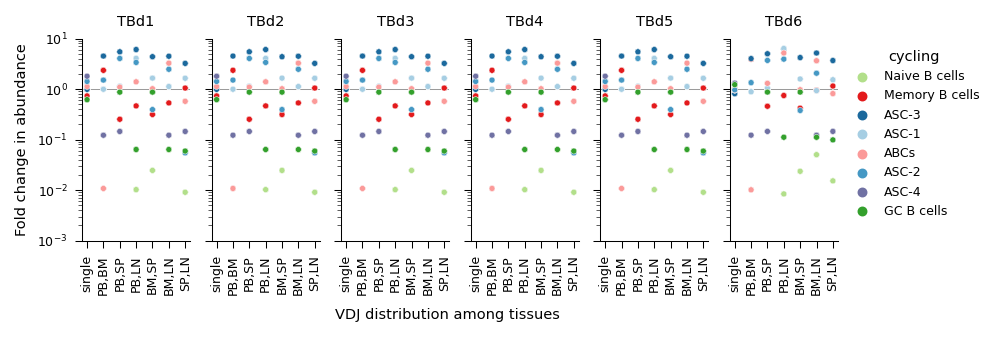

In [35]:
plt.style.use('./bursa.mplstyle')
bcelltype_colors = bcelltype_colors_alt
bcelltype_colors.update({'multiple':'k', 'rare celltype':'0.5'})
fig, axes = plt.subplots(1, 6, 
                         sharex=True, 
                         sharey=True,
                        figsize=(6.5,1.75))
axes = axes.flatten()

for i, subset in enumerate(tissue_distribution['VDJdistribution'].unique()):
    for d_it, donor in enumerate(donors):
        ax=axes[d_it]
        distributions = tissue_distribution[(tissue_distribution.donor==donor)]
        g = sns.scatterplot(distributions, 
                    x='VDJdistribution',
                    y='scaled_proportion',
                    hue='celltype',
                    palette=bcelltype_colors,
                   ax=ax,legend=((d_it==5)&(i==0)),
                    s=8
                    )
        if (d_it==5):
            g_legend = g
        ax.set_title(donor)
        for tick in ax.get_xticklabels():
            tick.set_rotation(90)
        ax.set_yscale('log')
        axes[0].set_ylabel('Fold change in abundance')
        ax.set_xlabel('')
        ax.set_ylim([10**-3,10])
        ax.axhline(y=1, color='0.5', lw=0.5,zorder=-1, alpha=0.2)
sns.move_legend(g_legend, frameon=False, loc='upper left', bbox_to_anchor=(1,1), title='cycling', markerscale=0.75)
sns.despine(fig)
fig.supxlabel('VDJ distribution among tissues', y=-0.2, fontsize=7)
# fig.tight_layout()
fig.savefig(f'../figures/si figures/celltype_sharing_by_donor.pdf', bbox_inches='tight')

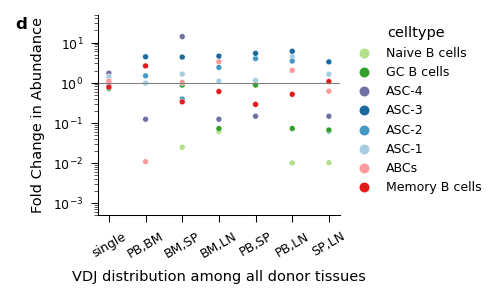

In [13]:
fig, axes = plt.subplots(1, 1, 
                         sharex=True, 
                         sharey=True,
                        figsize=(3.25,2))

tissue_data = tissue_distribution.groupby(['VDJdistribution','celltype'])[['proportion','scaled_proportion']].mean()
tissue_data = tissue_data.reset_index()
ax=axes


order = {'single':0, 
         'PB,BM':1,
         'BM,SP':2,
         'BM,LN':3,
         'PB,SP':4,
         'PB,LN':5,
         'SP,LN':6}
tissue_data['order'] = tissue_data.VDJdistribution.map(order)
tissue_data = tissue_data.sort_values("order")
ax=axes
g = sns.scatterplot(tissue_data, 
            x='VDJdistribution',
            y='scaled_proportion',
            hue='celltype',
            palette=bcelltype_colors,
            ax=ax,
            legend=True,
            s=8)

for tick in ax.get_xticklabels():
    tick.set_rotation(30)
ax.set_yscale('log')
ax.set_ylabel('Fold Change in Abundance')
ax.set_xlabel('VDJ distribution among all donor tissues')
ax.set_ylim([5*10**-4,50])
ax.axhline(y=1, lw=0.5, color='0.5')
sns.move_legend(g, 
                frameon=False, 
                loc='upper left', 
                bbox_to_anchor=(1,1),
               # title='cycling',
               markerscale=0.75)
sns.despine(fig)
fig.tight_layout()
ax.text(0,0.9, 'd', weight='bold', fontsize=8, transform=fig.transFigure)
fig.savefig(f'{FIGURE_OUTDIR}/Figure3d_multitissue_celltype.pdf', bbox_inches='tight')

# Now the same but for lymph nodes within donor 6

In [14]:
# create lookup tables for donor 6 lymph nodes
# first a list of tissues by donor
LN_list = ['SDLN1','SDLN2','SDLN3', 'MELN1']
samples = df_clean.groupby(['donor_subanatomical'])['emulsion'].unique().to_dict()
# # second VDJ presence in each tissue
targets = [x for x in celltypes if not x in ['rare celltype','multiple']]
# # third VDJ celltype in any tissue for the celltypes in targets
ln_presence_df = {}
ln_celltype_presence_df = {}
donor='TBd6'
donor_label_cols = [x for x in cell_counts_clean.columns if (x.startswith((donor,";")) and x.endswith('labels'))]
for subanatomical, emulsions in samples.items():
    tissue = donor_tissue.split("_")[-1]
    presence_cols = [f'{s}_binarized' for s in emulsions]

    ln_presence_df.update({subanatomical : cell_counts_clean[presence_cols].sum(axis=1)>0})
for celltype in targets:

    ln_celltype_presence_df.update({celltype:(cell_counts_clean[donor_label_cols] == celltype).any(axis=1)})
                        

ln_presence_df = pd.DataFrame(ln_presence_df)
ln_celltype_presence_df = pd.DataFrame(ln_celltype_presence_df)


In [15]:
full_distribution_df = []
pair_filter=  lambda pair: [x for x in ln_presence_df.columns
                                        if x in list(pair)]
print(pair_filter(("TBd6_SDLN1","TBd6_SDLN2")))



distribution_df = []
conditions = [
                ('single', ln_presence_df.sum(axis=1)==1),
                ("SDLN1,SDLN2",ln_presence_df[pair_filter(("TBd6_SDLN1","TBd6_SDLN2"))].sum(axis=1)==2),
                ("SDLN1,SDLN3",ln_presence_df[pair_filter(("TBd6_SDLN1","TBd6_SDLN3"))].sum(axis=1)==2),
                ("SDLN2,SDLN3",ln_presence_df[pair_filter(("TBd6_SDLN2","TBd6_SDLN3"))].sum(axis=1)==2),
                ("SDLN1,MELN1",ln_presence_df[pair_filter(("TBd6_SDLN1","TBd6_MELN1"))].sum(axis=1)==2),
                ("SDLN2,MELN1",ln_presence_df[pair_filter(("TBd6_SDLN2","TBd6_MELN1"))].sum(axis=1)==2),
                ("SDLN3,MELN1",ln_presence_df[pair_filter(("TBd6_SDLN3","TBd6_MELN1"))].sum(axis=1)==2),
            ]
for name, condition in conditions:
    distribution = calculate_distribution(ln_celltype_presence_df, 
                    index_mask=condition,
                    name=name)
    distribution_df.append(distribution)
distribution_df = pd.concat(distribution_df, axis=1).T
distribution_df['donor'] = donor
distribution_df = distribution_df.reset_index().rename(columns={'index':'VDJdistribution'})
LN_distribution = distribution_df.melt(id_vars=['VDJdistribution', 'donor'],
                           var_name='celltype', 
                           value_name='proportion')

['TBd6_SDLN1', 'TBd6_SDLN2']


In [16]:
null_distribution = []
# single tissue nulls
dist_df = []


# conditions = [(tissue, simple_presence_dfs[donor][tissue]) for tissue in tissue_list if tissue in simple_presence_dfs[donor].columns]
# for name, condition in conditions:
#     distribution = calculate_distribution(simple_celltype_dfs[donor], 
#                     index_mask=condition,
#                     name=name)

conditions = [("_".join([donor,LN]), ln_presence_df["_".join([donor,LN])]) for LN in LN_list]
for name, condition in conditions:
    distribution = calculate_distribution(ln_celltype_presence_df, 
                    index_mask=condition,
                    name=name)
    dist_df.append(distribution)
dist_df = pd.concat(dist_df, axis=1).T

pairs=[ "SDLN1,SDLN2",
        "SDLN1,SDLN3",
        "SDLN2,SDLN3",
        "SDLN1,MELN1",
        "SDLN2,MELN1",
        "SDLN3,MELN1"]

pair_nulls = []
for pair in pairs:
    t1, t2 = pair.split(",")
    i1, i2 = "_".join([donor,t1]), "_".join([donor,t2])
    if (i1 in dist_df.index) and (i2 in dist_df.index):
        t1_null = dist_df.loc[i1]
        t2_null = dist_df.loc[i2]
        pair_null = 1 - (1- t1_null)*(1 - t2_null)
        pair_null.name = pair
        pair_nulls.append(pair_null)
print(pair_nulls)

pair_nulls = pd.concat(pair_nulls, axis=1).T
dist_df = pd.concat([dist_df,pair_nulls])
dist_df['donor'] = donor
total_count = ln_presence_df.sum()
dist_df['cells'] = dist_df.index.map(total_count)
single_tissue_rows = dist_df['cells'].notna()
weights = dist_df.loc[single_tissue_rows, 'cells']/dist_df.loc[single_tissue_rows, 'cells'].sum() 
dist_df.loc['single',:] =  ((dist_df.loc[single_tissue_rows, [x for x in dist_df.columns if x in celltypes]].T * weights).T).sum() 
dist_df.loc['single', 'donor'] = donor
dist_df = dist_df.reset_index().rename(columns={'index':'VDJdistribution'})

null_distribution.append(dist_df)
null_distribution = pd.concat(null_distribution)


null_distribution = null_distribution.melt(id_vars=['VDJdistribution', 'donor'],
                           var_name='celltype', 
                           value_name='proportion').set_index(['donor', 'VDJdistribution','celltype']).to_dict()
LN_distribution['proportion'] = LN_distribution['proportion'] + 10**-4
LN_distribution['scaled_proportion'] = (LN_distribution['proportion']+10**-4)/(LN_distribution.apply(lambda x: null_distribution['proportion'].get((x.donor, 
                                                                                                                x.VDJdistribution,
                                                                                                                x.celltype),1), axis=1)+10**-4)

[Naive B cells     0.899306
Memory B cells    0.523889
ASC-3             0.005650
ASC-1             0.000975
ABCs              0.008658
ASC-2             0.000000
ASC-4             0.000000
GC B cells        0.001364
Name: SDLN1,SDLN2, dtype: float64, Naive B cells     0.870908
Memory B cells    0.566251
ASC-3             0.035993
ASC-1             0.001240
ABCs              0.011832
ASC-2             0.001010
ASC-4             0.000000
GC B cells        0.002493
Name: SDLN1,SDLN3, dtype: float64, Naive B cells     0.852834
Memory B cells    0.592046
ASC-3             0.036699
ASC-1             0.001177
ABCs              0.010920
ASC-2             0.001010
ASC-4             0.000000
GC B cells        0.002042
Name: SDLN2,SDLN3, dtype: float64, Naive B cells     0.862258
Memory B cells    0.616224
ASC-3             0.003357
ASC-1             0.000519
ABCs              0.006045
ASC-2             0.000179
ASC-4             0.000000
GC B cells        0.001444
Name: SDLN1,MELN1, dtype: floa

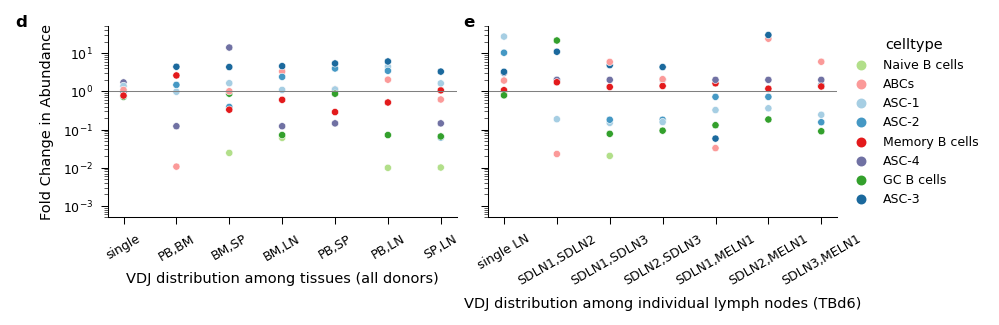

In [30]:
fig, axes = plt.subplots(1, 2, 
                         sharey=True,
                        figsize=(6.5,2.1))

for it, distribution in enumerate([tissue_distribution, LN_distribution]):
    data = distribution.groupby(['VDJdistribution','celltype'])[['proportion','scaled_proportion']].mean()
    data = data.reset_index()
    ax=axes[it]

    if it==1:
        data.loc[data.VDJdistribution == 'single', 'VDJdistribution'] = 'single LN'
        order = {'single LN':0, 
                'SDLN1,SDLN2':1,
                'SDLN1,SDLN3':2,
                'SDLN2,SDLN3':3,
                'SDLN1,MELN1':4,
                'SDLN2,MELN2':5,
                'SDLN3,MELN3':6}
        ax.set_xlabel('VDJ distribution among individual lymph nodes (TBd6)')

    else:
        order = {'single':0, 
                'PB,BM':1,
                'BM,SP':2,
                'BM,LN':3,
                'PB,SP':4,
                'PB,LN':5,
                'SP,LN':6}
        ax.set_xlabel('VDJ distribution among tissues (all donors)')

        
    data['order'] = data.VDJdistribution.map(order)
    data = data.sort_values("order")
    g = sns.scatterplot(data, 
                x='VDJdistribution',
                y='scaled_proportion',
                hue='celltype',
                palette=bcelltype_colors,
                ax=ax,
                legend=(it==1),
                s=12)

    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    ax.set_yscale('log')
    ax.set_ylabel('Fold Change in Abundance')
    ax.set_ylim([5*10**-4,50])
    ax.axhline(y=1, lw=0.5, color='0.5')
sns.move_legend(g, 
                frameon=False, 
                loc='upper left', 
                bbox_to_anchor=(1,1),
            # title='cycling',
        markerscale=0.75)
sns.despine(fig)
fig.tight_layout()

ax.text(-0.01, 0.95, 'd', weight='bold', fontsize=8, transform=fig.transFigure)
ax.text(0.45, 0.95, 'e', weight='bold', fontsize=8, transform=fig.transFigure)

fig.savefig(f'{FIGURE_OUTDIR}/Figure3de_celltypes.pdf', bbox_inches='tight')